In [1]:
import os
os.getcwd()


'D:\\PROJ'

## IMPORTS



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime as dt


## INITIAL DATA INSPECTION

In [4]:
file_path = "data/DATA_SET.csv"

df_peek = pd.read_csv(file_path, nrows=5)

df_peek.info()
display(df_peek)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Invoice      5 non-null      int64  
 1   StockCode    5 non-null      object 
 2   Description  5 non-null      object 
 3   Quantity     5 non-null      int64  
 4   InvoiceDate  5 non-null      object 
 5   Price        5 non-null      float64
 6   Customer ID  5 non-null      float64
 7   Country      5 non-null      object 
dtypes: float64(2), int64(2), object(4)
memory usage: 452.0+ bytes


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Data Loading and Cleaning

In [5]:
df = pd.read_csv(file_path, encoding="unicode_escape")

# Remove records without a valid customer identifier
df = df.dropna(subset=["Customer ID"])

# Convert invoice date to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Compute total transaction value
df["TotalSum"] = df["Quantity"] * df["Price"]

# Exclude cancelled or invalid transactions
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]

# Verify dataset size after cleaning
print(f"Cleaned dataset size: {df.shape}")
df.head()


Cleaned dataset size: (805549, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSum
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


## RFM Metric Calculation

In [6]:
# Define snapshot date for recency calculation
snapshot_date = df["InvoiceDate"].max() + dt.timedelta(days=1)

# Aggregate transactional data to customer-level RFM metrics
rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "Invoice": "nunique",                                     # Frequency
    "TotalSum": "sum"                                         # Monetary
})

# Standardize column names
rfm.rename(columns={
    "InvoiceDate": "Recency",
    "Invoice": "Frequency",
    "TotalSum": "MonetaryValue"
}, inplace=True)

# Preview RFM table
rfm.head()

,Recency,Frequency,MonetaryValue
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


## Feature Transformation and scaling

In [7]:
# Apply log transformation to reduce skewness
rfm_log = np.log(rfm + 1)

# Standardize features for clustering
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_log)

# Convert scaled array back to DataFrame
rfm_normalized = pd.DataFrame(
    rfm_normalized,
    index=rfm.index,
    columns=rfm.columns
)

# Summary statistics after transformation
rfm_normalized.describe().round(2)

,Recency,Frequency,MonetaryValue
count,5878.00,5878.00,5878.00
mean,-0.00,0.00,-0.00
std,1.00,1.00,1.00
min,-2.41,-1.06,-3.94
25%,-0.74,-1.06,-0.71
50%,0.08,-0.20,-0.02
75%,0.95,0.65,0.65
max,1.38,5.48,4.67


## Optimal Cluster Selection (elbow method)

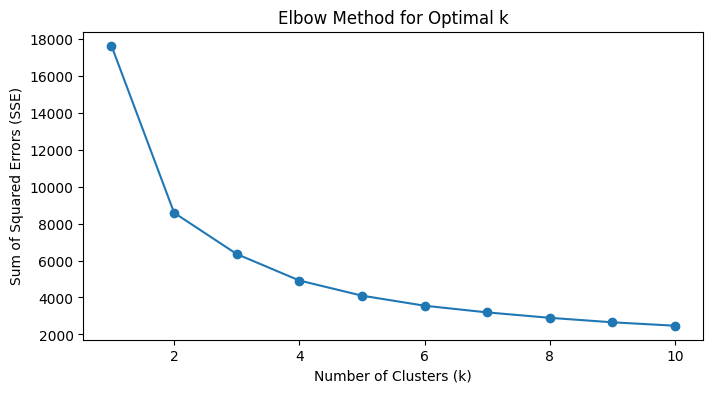

In [8]:
# Compute sum of squared errors (SSE) for different cluster counts
sse = {}

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_

# Visualize the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(list(sse.keys()), list(sse.values()), marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal k")
plt.show()

## Customer Segmentation using K-Means


In [9]:
# Fit K-Means model using the selected number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_normalized)

# Generate cluster-level RFM profiles
cluster_analysis = rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "MonetaryValue": ["mean", "count"]
}).round(1)

# Review segment characteristics
cluster_analysis


Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         370.6       1.6         413.1  2455
1          32.5      20.1       11504.6  1132
2         103.3       4.5        1617.7  2291

## Business Interpretation of Customer Segments

In [10]:
# Map cluster labels to business-friendly segment names
cluster_map = {
    0: "At-Risk",
    1: "Champions",
    2: "Potential Loyalists"
}

rfm["Segment"] = rfm["Cluster"].map(cluster_map)

# Review segment distribution
rfm["Segment"].value_counts()

# Preview labeled customer segments
rfm[["Recency", "Frequency", "MonetaryValue", "Segment"]].head()


,Recency,Frequency,MonetaryValue,Segment
Customer ID,,,,
12346.0,326,12,77556.46,Champions
12347.0,2,8,5633.32,Champions
12348.0,75,5,2019.40,Potential Loyalists
12349.0,19,4,4428.69,Potential Loyalists
12350.0,310,1,334.40,At-Risk


## Export Segmented Data for Visualization

In [11]:
# Export customer-level RFM segmentation results
rfm.to_csv("outputs/final_customer_segments.csv", index=False)
print("Success! Your segmented data is ready for Power BI.")

Success! Your segmented data is ready for Power BI.


## Segment-Level Summary Output


In [12]:
# Create segment-level summary metrics
segment_summary = (
    rfm.groupby("Segment")
       .agg(
           Customers=("Segment", "count"),
           Avg_Recency=("Recency", "mean"),
           Avg_Frequency=("Frequency", "mean"),
           Avg_MonetaryValue=("MonetaryValue", "mean")
       )
       .round(1)
)

# Export segment summary for reporting and visualization
segment_summary.to_csv("outputs/segment_summary.csv", index=False)
